In [11]:
from image_loader import ImageLoader, ImagePreprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import cv2
import matplotlib.pyplot as plt
from train_svm_model import deskew, load_images, learn, predict
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [2]:
img_size = (100, 100)
train_dir = "images/train/train"
test_dir = "images/test/test"
classes = {"cat": 0, "dog": 1}
SZ = img_size[0]

In [3]:
train_loader = ImageLoader(dir_name=train_dir)


In [4]:
train_images = []
train_labels = []


In [5]:
for _ in range(50):
    img = train_loader.get_one_image(labels=classes, new_size=img_size)
    train_images.append(img["data"])
    train_labels.append(img["target"])

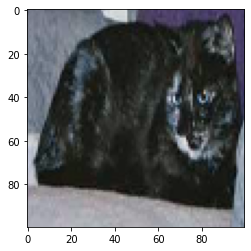

In [7]:
plt.imshow(train_images[34])

In [8]:
gray_scaled_train = []
for im in train_images:
    gray_scaled_train.append(np.uint8(train_loader.rgb2gray(im)))

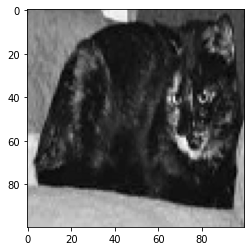

In [9]:
plt.imshow(gray_scaled_train[34], cmap="gray")

In [10]:
unique, count = np.unique(train_labels, return_counts=True)
dict(zip(unique, count))

{0: 27, 1: 23}

In [16]:
def simple_preproc(img):
    return np.resize(img, (img.shape[0]*img.shape[0], ))/255.0

In [19]:
train_set = [simple_preproc(img) for img in gray_scaled_train]

In [47]:
def train_mlp(n_epoch, batch_size, train_dir, clf, img_size, classes):
    loader = ImageLoader(dir_name=train_dir)
    for i in range(n_epoch):
        imgs = []
        lbs = []
        for batch in range(batch_size):
            img = loader.get_one_image(new_size=img_size, labels=classes)
            imgs.append(simple_preproc(img["data"]))
            lbs.append(img["target"])
        print(f"loaded {batch_size} images")
        train_n = int(0.9 * len(lbs))
        train_imgs, test_imgs = np.split(imgs, [train_n])
        train_lbs, test_lbs = np.split(lbs, [train_n])
        clf.fit(train_imgs, train_lbs)
        print(f'epoch: {i} \t Accuracy: {accuracy_score(clf.predict(test_imgs), test_lbs)*100}')
        
            
    

In [33]:
mlp_model = MLPClassifier(max_iter=1000)

In [34]:
parameters = {"activation": ["relu", "tanh", "logistic", "identity"],
             "solver": ["sgd", "adam"],
             "hidden_layer_sizes": [(100,), (100, 100), (200, ), (200, 200)]}

In [35]:
grid = GridSearchCV(mlp_model, param_grid=parameters, n_jobs=2)

In [36]:
grid.fit(train_set, train_labels)

GridSearchCV(estimator=MLPClassifier(max_iter=1000), n_jobs=2,
             param_grid={'activation': ['relu', 'tanh', 'logistic', 'identity'],
                         'hidden_layer_sizes': [(100,), (100, 100), (200,),
                                                (200, 200)],
                         'solver': ['sgd', 'adam']})

In [37]:
grid.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (200,), 'solver': 'adam'}

In [38]:
mlp_model = MLPClassifier(max_iter=1000, solver="adam", hidden_layer_sizes=(200,), activation="logistic")

In [39]:
grid.best_score_

0.5800000000000001

In [40]:
lr_grid = GridSearchCV(mlp_model, param_grid={"learning_rate": ["constant", "invscaling", "adaptive"]})

In [41]:
lr_grid.fit(train_set, train_labels)

GridSearchCV(estimator=MLPClassifier(activation='logistic',
                                     hidden_layer_sizes=(200,), max_iter=1000),
             param_grid={'learning_rate': ['constant', 'invscaling',
                                           'adaptive']})

In [43]:
lr_grid.best_params_

{'learning_rate': 'invscaling'}

In [45]:
mlp_model = MLPClassifier(solver="adam", hidden_layer_sizes=(200,), activation="logistic", learning_rate="invscaling")

In [48]:
train_mlp(n_epoch=1, batch_size=25000, train_dir=train_dir, clf=mlp_model, img_size=img_size, classes=classes)

loaded 25000 images
epoch: 0 	 Accuracy: 76.84


In [50]:
dump(mlp_model, "mlp_classifier.joblib")

['mlp_classifier.joblib']

In [53]:
def predict_mlp(model, img_name, dir_name, new_size):
    image_loader = ImageLoader(dir_name=dir_name)
    img = image_loader.get_one_image(new_size=new_size, path=img_name)
    img = simple_preproc(img["data"])
    return model.predict([img])

In [57]:
predict_mlp(model=mlp_model, img_name="4.jpg", dir_name=test_dir, new_size=img_size)

array([1])